# CIC-AndMal2017

## Importların Yapılması

In [4]:
!pip install xgboost

In [5]:
!pip install lightgbm

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## Verilerin Birleştirilmesi

In [8]:
malware_data = pd.read_csv("malware_data.csv", low_memory=False)
benign_data = pd.read_csv("benign_data.csv", low_memory=False)

malware_data = malware_data.drop(['Unnamed: 0', 'Flow ID', ' Timestamp'], axis=1)
benign_data = benign_data.drop(['Flow ID', ' Timestamp'], axis=1)

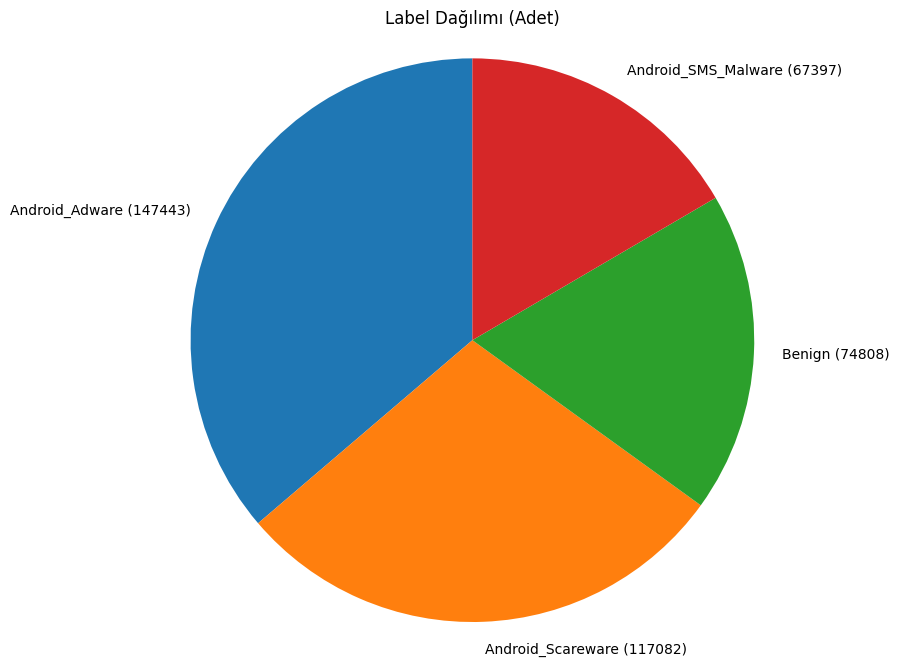

In [9]:
merged_data = pd.concat([malware_data, benign_data], axis=0).reset_index(drop=True)
label_counts = merged_data['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    label_counts,
    labels=[f"{label} ({count})" for label, count in zip(label_counts.index, label_counts)],
    startangle=90
)
plt.title("Label Dağılımı (Adet)")
plt.axis('equal')
plt.show()

              Malware Port Ratio  Benign Port Ratio  Difference
 Source Port                                                   
60774                     0.0045             0.0014      0.0030
43477                     0.0023             0.0001      0.0022
80                        0.0389             0.0371      0.0018
8612                      0.0006             0.0000      0.0006
46360                     0.0006             0.0000      0.0006
5228                      0.0005             0.0011     -0.0007
0                         0.0060             0.0080     -0.0019
443                       0.0546             0.0742     -0.0196


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):


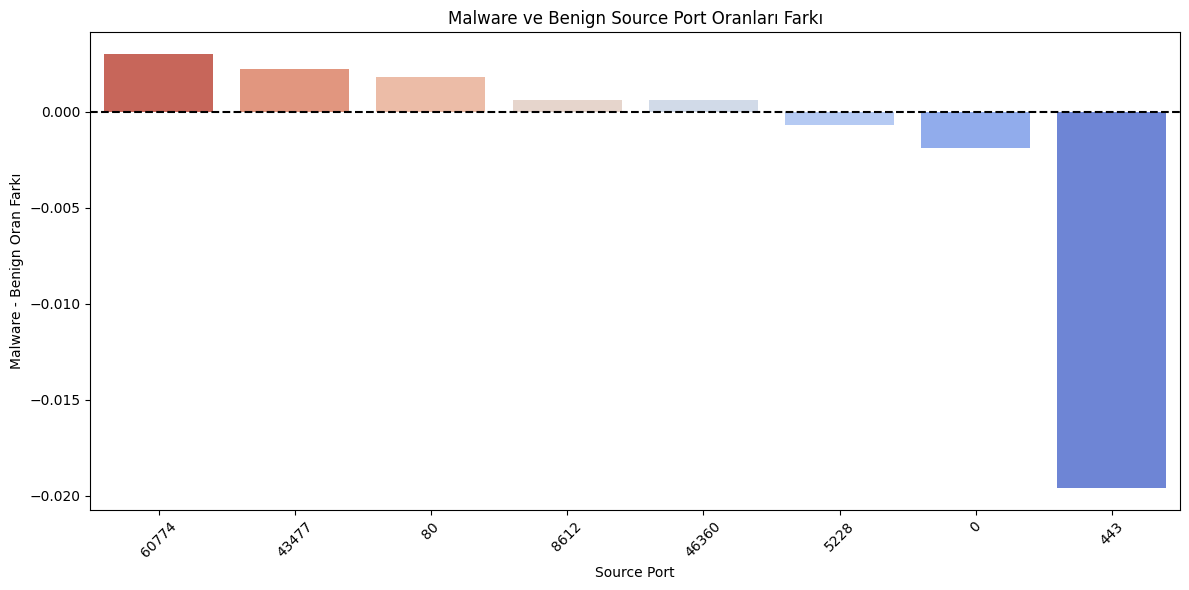

In [10]:
data = merged_data

total_malware = data[data['Label'] != 'Benign'].shape[0]
total_benign = data[data['Label'] == 'Benign'].shape[0]

malware_counts = data[data['Label'] != 'Benign'][' Source Port'].value_counts()
benign_counts = data[data['Label'] == 'Benign'][' Source Port'].value_counts()

top_ports = list(set(malware_counts.index) | set(benign_counts.index))

malware_port_ratio = malware_counts / total_malware
benign_port_ratio = benign_counts / total_benign

port_df = pd.DataFrame({
    'Malware Port Ratio': malware_port_ratio.reindex(top_ports).fillna(0),
    'Benign Port Ratio': benign_port_ratio.reindex(top_ports).fillna(0)
})

port_df['Difference'] = port_df['Malware Port Ratio'] - port_df['Benign Port Ratio']
port_df = port_df.round(4)

threshold = 0.0005
filtered_ports = port_df[port_df['Difference'].abs() > threshold].sort_values('Difference', ascending=False)

print(filtered_ports)

plt.figure(figsize=(12,6))

sns.barplot(x=filtered_ports.index.astype(str), y=filtered_ports['Difference'], palette=sns.color_palette("coolwarm", len(filtered_ports))[::-1])

plt.title('Malware ve Benign Source Port Oranları Farkı')
plt.xlabel('Source Port')
plt.ylabel('Malware - Benign Oran Farkı')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

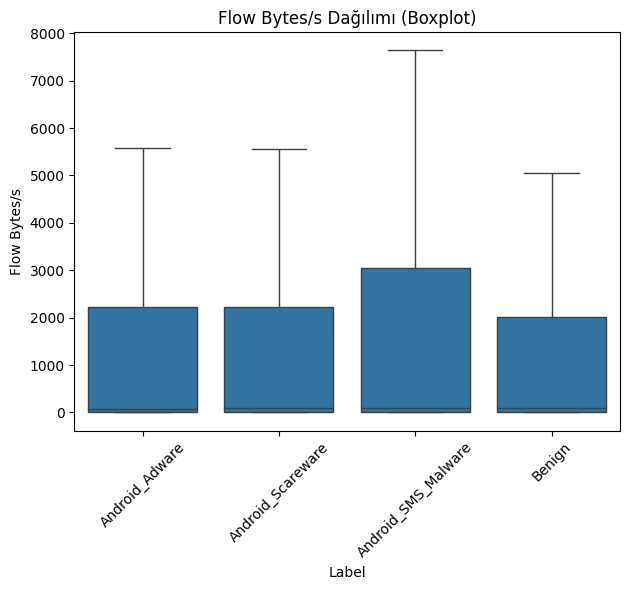

In [11]:
feature = 'Flow Bytes/s'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y=feature, data=merged_data, showfliers=False)
plt.title(f'{feature} Dağılımı (Boxplot)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Veri Ön İşleme

In [12]:
print(merged_data.isnull().sum().sum())

116


In [13]:
merged_data = merged_data.fillna(merged_data.mean(numeric_only=True))

In [14]:
print(merged_data.isnull().sum().sum())

6


In [15]:
def safe_to_float(val):
    try:
        return float(val)
    except:
        return np.nan

merged_data[' Down/Up Ratio'] = merged_data[' Down/Up Ratio'].apply(safe_to_float)
merged_data[' Down/Up Ratio'] = merged_data[' Down/Up Ratio'].fillna(0).astype(int)
print(merged_data[' Down/Up Ratio'].unique().tolist())

[1, 0, 2, 3, 8, 4, 5, 9, 6, 12, 7, 10, 11, 75]


In [16]:
print(merged_data['Fwd Avg Bytes/Bulk'].unique().tolist())
merged_data=merged_data.drop('Fwd Avg Bytes/Bulk',axis=1)

['0', 'BENIGN', '0.0', nan, 0.0]


In [17]:
merged_data[' CWE Flag Count'] = merged_data[' CWE Flag Count'].fillna(0)

In [18]:
print(merged_data.isnull().sum().sum())

0


In [19]:
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object':
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

data1=labelencoder(merged_data)

## Train-Test Ayırma

In [20]:
X = data1.drop('Label', axis=1)
y = data1['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

## 4 Class Classification

--- Decision Tree ---
Accuracy: 0.6312295626091019
Weighted F1 Score: 0.6314457427252469
Confusion Matrix:
 [[20638  1648  4529  2674]
 [ 1465  8211  2198  1605]
 [ 4573  2750 13822  2271]
 [ 2572  1560  2153  8677]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     29489
           1       0.58      0.61      0.59     13479
           2       0.61      0.59      0.60     23416
           3       0.57      0.58      0.57     14962

    accuracy                           0.63     81346
   macro avg       0.62      0.62      0.62     81346
weighted avg       0.63      0.63      0.63     81346



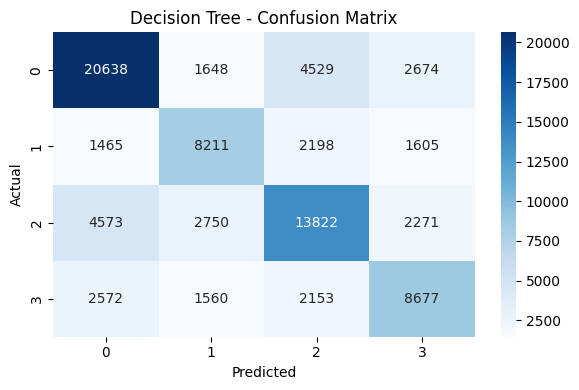

--- Random Forest ---
Accuracy: 0.6015046836968013
Weighted F1 Score: 0.5983281065548882
Confusion Matrix:
 [[21393   769  5277  2050]
 [ 2199  7026  2667  1587]
 [ 6459  2048 13043  1866]
 [ 3623  1312  2559  7468]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68     29489
           1       0.63      0.52      0.57     13479
           2       0.55      0.56      0.56     23416
           3       0.58      0.50      0.53     14962

    accuracy                           0.60     81346
   macro avg       0.60      0.58      0.58     81346
weighted avg       0.60      0.60      0.60     81346



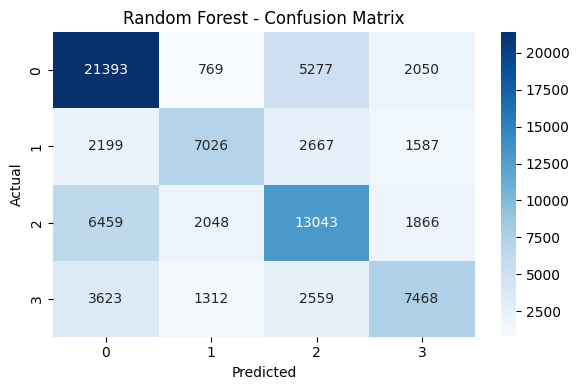

--- XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [17:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.5546554225161655
Weighted F1 Score: 0.5389789003127591
Confusion Matrix:
 [[22758   109  5584  1038]
 [ 3669  4749  3635  1426]
 [ 8623   707 12839  1247]
 [ 6399  1258  2532  4773]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.77      0.64     29489
           1       0.70      0.35      0.47     13479
           2       0.52      0.55      0.53     23416
           3       0.56      0.32      0.41     14962

    accuracy                           0.55     81346
   macro avg       0.58      0.50      0.51     81346
weighted avg       0.57      0.55      0.54     81346



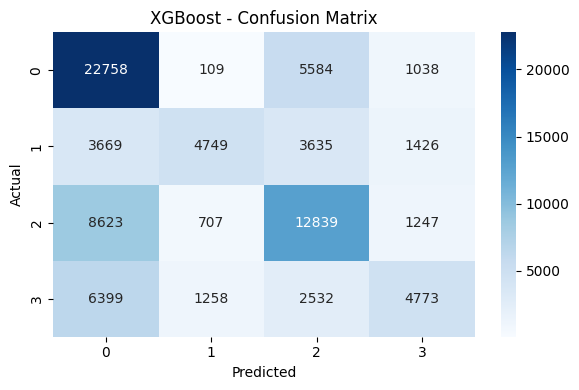

--- LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15128
[LightGBM] [Info] Number of data points in the train set: 325384, number of used features: 71
[LightGBM] [Info] Start training from score -1.014711
[LightGBM] [Info] Start training from score -1.797542
[LightGBM] [Info] Start training from score -1.245271
[LightGBM] [Info] Start training from score -1.693231
Accuracy: 0.5505372114178939
Weighted F1 Score: 0.5348098070247566
Confusion Matrix:
 [[22568    47  5999   875]
 [ 3766  4996  3523  1194]
 [ 8988   685 12807   936]
 [ 6923  1225  2401  4413]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.77      0.63     29489
    

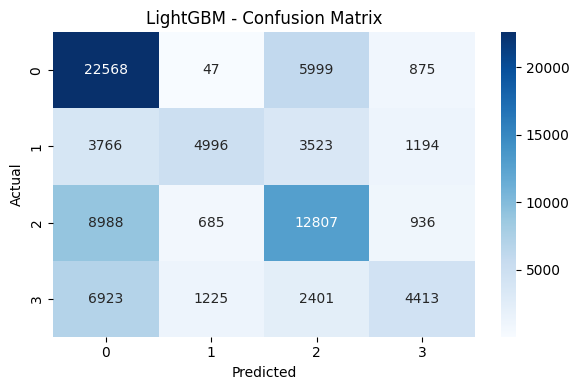

--- KNN ---
Accuracy: 0.42447077914095344
Weighted F1 Score: 0.41048697555023855
Confusion Matrix:
 [[18812  2647  5726  2304]
 [ 4836  4011  3423  1209]
 [ 9598  3492  8222  2104]
 [ 5962  1935  3581  3484]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.64      0.55     29489
           1       0.33      0.30      0.31     13479
           2       0.39      0.35      0.37     23416
           3       0.38      0.23      0.29     14962

    accuracy                           0.42     81346
   macro avg       0.40      0.38      0.38     81346
weighted avg       0.41      0.42      0.41     81346



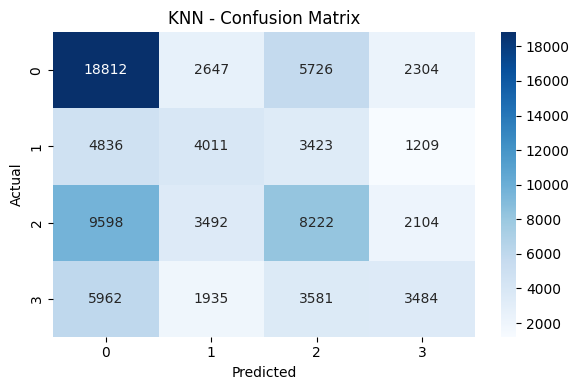

In [21]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Weighted F1 Score:", weighted_f1)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    cr = classification_report(y_test, y_pred)
    print("Classification Report:\n", cr)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

Accuracy: 0.6312295626091019
Weighted F1 Score: 0.6314457427252469
Confusion Matrix:
 [[20638  1648  4529  2674]
 [ 1465  8211  2198  1605]
 [ 4573  2750 13822  2271]
 [ 2572  1560  2153  8677]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     29489
           1       0.58      0.61      0.59     13479
           2       0.61      0.59      0.60     23416
           3       0.57      0.58      0.57     14962

    accuracy                           0.63     81346
   macro avg       0.62      0.62      0.62     81346
weighted avg       0.63      0.63      0.63     81346



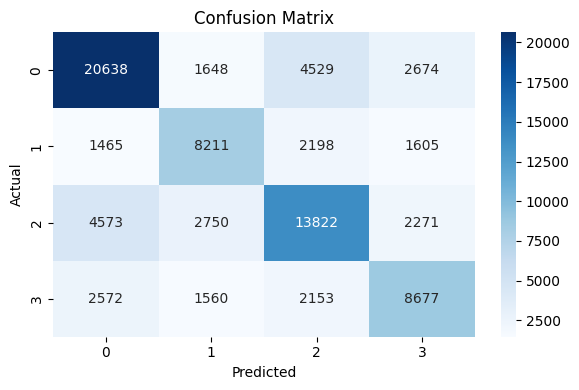

In [22]:
model = DecisionTreeClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Weighted F1 Score:", weighted_f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Modeli En Çok Etkileyen Özellikler

En önemli 10 özellik:
 Source Port              0.199507
 Destination IP           0.125020
 Source IP                0.067978
 Flow IAT Min             0.039452
Flow Bytes/s              0.038542
 Destination Port         0.034055
Init_Win_bytes_forward    0.030973
Fwd Packets/s             0.029544
 Flow Packets/s           0.025463
 Bwd Packets/s            0.024731
dtype: float64


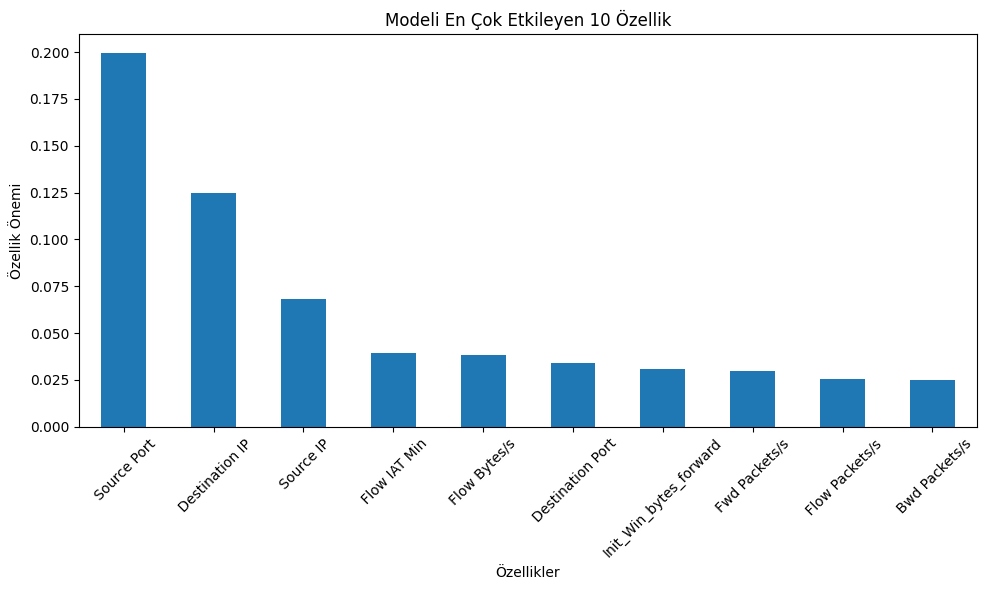

In [23]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print("En önemli 10 özellik:")
print(sorted_importances.head(10))

plt.figure(figsize=(10, 6))
sorted_importances.head(10).plot(kind='bar')
plt.title("Modeli En Çok Etkileyen 10 Özellik")
plt.ylabel("Özellik Önemi")
plt.xlabel("Özellikler")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
threshold = 0.0125
important_features = feature_importances[feature_importances > threshold].index.tolist()
print(important_features)

[' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Max', ' Flow IAT Min', ' Fwd IAT Min', 'Fwd Packets/s', ' Bwd Packets/s', ' CWE Flag Count', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward']


## En Önemli Özellikler İle Yeniden Test Etme

Accuracy: 0.6532835050279054
Weighted F1 Score: 0.6536499537211576
Confusion Matrix:
 [[21129  1604  4305  2451]
 [ 1347  8444  2132  1556]
 [ 4249  2688 14451  2028]
 [ 2322  1545  1977  9118]]


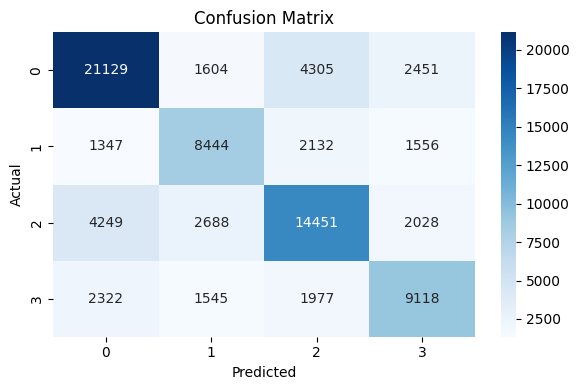

In [25]:
X_top = X[important_features]
X_top

X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)

model = DecisionTreeClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Weighted F1 Score:", weighted_f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## Bagging Classifier - 4 Class

In [26]:
base_tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")

model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=50,
    max_samples=0.9,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Weighted F1 Score:", weighted_f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.7098443684999877
Weighted F1 Score: 0.7081716713747501
Confusion Matrix:
 [[23665   612  3752  1460]
 [ 1557  8610  2108  1204]
 [ 4341  1782 16049  1244]
 [ 2657  1157  1729  9419]]


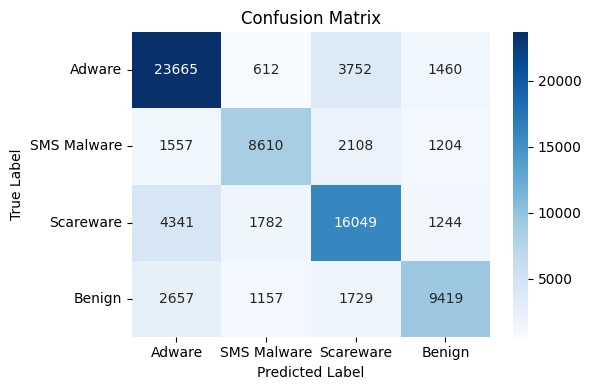

In [27]:
labels = ['Adware', 'SMS Malware', 'Scareware', 'Benign']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Binary Classification


--- Decision Tree ---
Accuracy: 0.8442701546480467
Weighted F1 Score: 0.8440024946253277

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57     14962
           1       0.90      0.91      0.90     66384

    accuracy                           0.84     81346
   macro avg       0.74      0.74      0.74     81346
weighted avg       0.84      0.84      0.84     81346

Confusion Matrix:
 [[ 8562  6400]
 [ 6268 60116]]


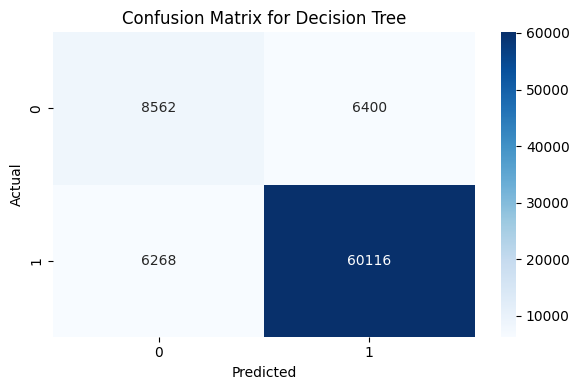


--- Random Forest ---
Accuracy: 0.8628820101787427
Weighted F1 Score: 0.8440916237190937

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.38      0.51     14962
           1       0.87      0.97      0.92     66384

    accuracy                           0.86     81346
   macro avg       0.81      0.68      0.71     81346
weighted avg       0.85      0.86      0.84     81346

Confusion Matrix:
 [[ 5701  9261]
 [ 1893 64491]]


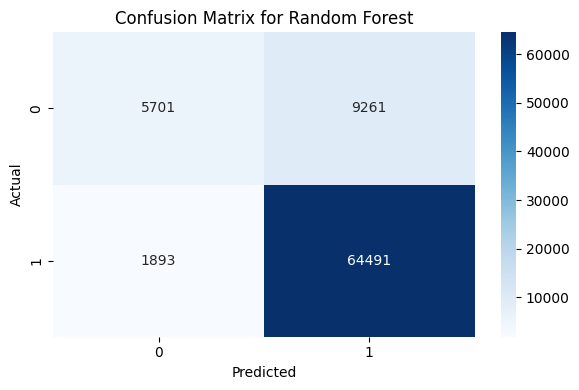


--- K-Nearest Neighbors ---
Accuracy: 0.7991542300789222
Weighted F1 Score: 0.7688055098122194

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.19      0.26     14962
           1       0.84      0.94      0.88     66384

    accuracy                           0.80     81346
   macro avg       0.62      0.56      0.57     81346
weighted avg       0.76      0.80      0.77     81346

Confusion Matrix:
 [[ 2846 12116]
 [ 4222 62162]]


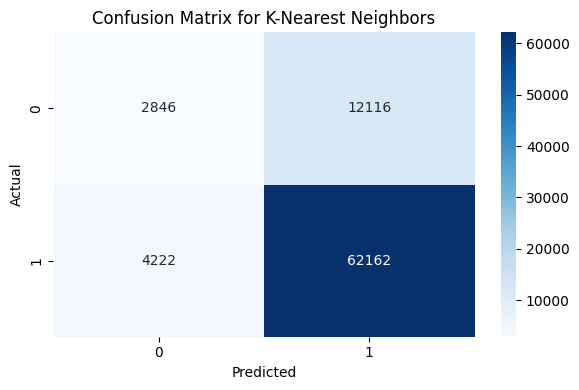


--- XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [18:03:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8386767634548717
Weighted F1 Score: 0.797518406606695

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.19      0.30     14962
           1       0.84      0.98      0.91     66384

    accuracy                           0.84     81346
   macro avg       0.79      0.59      0.61     81346
weighted avg       0.82      0.84      0.80     81346

Confusion Matrix:
 [[ 2865 12097]
 [ 1026 65358]]


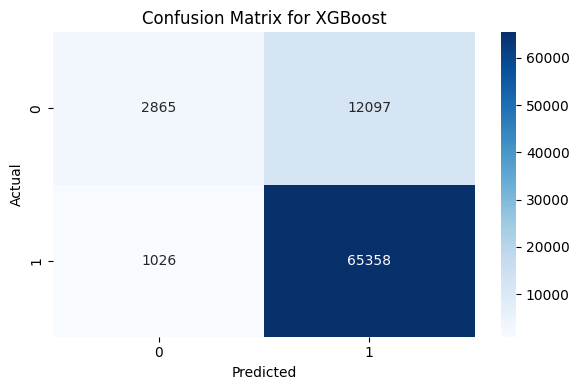

In [28]:
y_binary = y.apply(lambda x: 0 if x == 3 else 1)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_top, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42, class_weight="balanced")),
    ("Random Forest", RandomForestClassifier(random_state=42, class_weight="balanced")),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
]

for model_name, model in models:
    print(f"\n--- {model_name} ---")

    model.fit(X_train_bin, y_train_bin)

    y_pred_bin = model.predict(X_test_bin)

    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    weighted_f1 = f1_score(y_test_bin, y_pred_bin, average='weighted')

    print("Accuracy:", accuracy)
    print("Weighted F1 Score:", weighted_f1)
    print("\nClassification Report:")
    print(classification_report(y_test_bin, y_pred_bin))

    cm = confusion_matrix(y_test_bin, y_pred_bin)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [29]:
y_binary = y.apply(lambda x: 0 if x == 3 else 1)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_top, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

base_tree = DecisionTreeClassifier(random_state=42, class_weight="balanced")

model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=50,
    max_samples=0.9,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_bin, y_train_bin)
y_pred_bin = model.predict(X_test_bin)

print(classification_report(y_test_bin, y_pred_bin))
print(confusion_matrix(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.80      0.50      0.61     14962
           1       0.90      0.97      0.93     66384

    accuracy                           0.88     81346
   macro avg       0.85      0.73      0.77     81346
weighted avg       0.88      0.88      0.87     81346

[[ 7425  7537]
 [ 1832 64552]]


# CICMalDroid 2020



## 1. Importların Yapılması

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

## 2. Verinin Okunması ve Dağılımına Bakılması

In [32]:
df = pd.read_csv("/content/CICMalDroid_2020.csv", low_memory=False)
print(df.shape)
print(df.isnull().sum().sum())

(11598, 471)
0


In [33]:
label_map = {
    1: 'Adware',
    2: 'Banking',
    3: 'SMS malware',
    4: 'Riskware',
    5: 'Benign'
}

df["Class"].unique()

array([1, 2, 3, 4, 5])

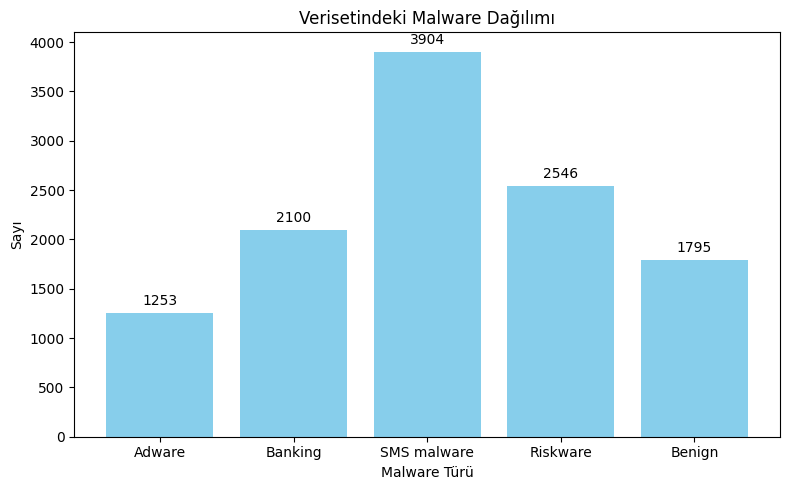

In [34]:
sorted_labels = list(range(1, 6))
labels = [label_map[i] for i in sorted_labels]
counts = [df['Class'].value_counts().get(i, 0) for i in sorted_labels]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel('Malware Türü')
plt.ylabel('Sayı')
plt.title('Verisetindeki Malware Dağılımı')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, str(count),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [35]:
df.groupby('Class')['getDisplayInfo'].mean()

,getDisplayInfo
Class,
1,197.747007
2,6.928571
3,7.097336
4,12.421838
5,19.852925


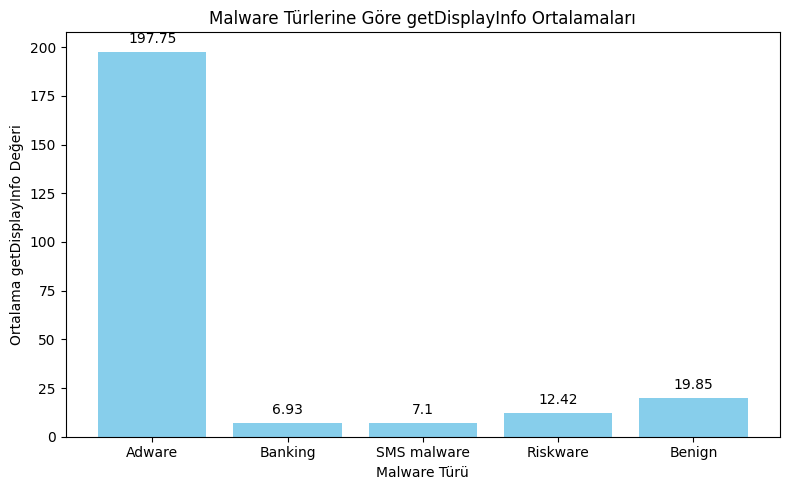

In [36]:
means = df.groupby('Class')['getDisplayInfo'].mean().rename(index=label_map)

labels = means.index.tolist()
values = means.values.tolist()

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values, color='skyblue')
plt.xlabel('Malware Türü')
plt.ylabel('Ortalama getDisplayInfo Değeri')
plt.title('Malware Türlerine Göre getDisplayInfo Ortalamaları')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [37]:
df.groupby('Class')['access'].mean()

,access
Class,
1,110.422187
2,1069.019524
3,14.689549
4,206.153967
5,315.550975


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  if (await self.run_code(code, result,  async_=asy)):


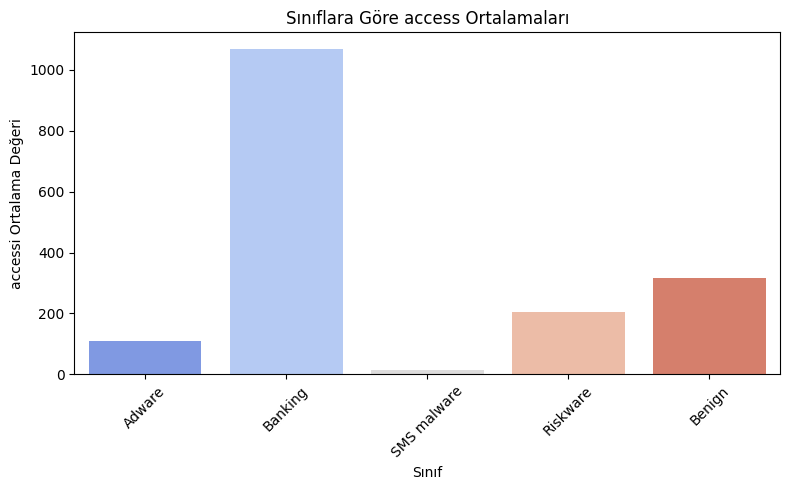

In [38]:
means = df.groupby('Class')['access'].mean().rename(index=label_map)

plt.figure(figsize=(8,5))
sns.barplot(x=means.index, y=means.values, palette='coolwarm')
plt.title('Sınıflara Göre access Ortalamaları')
plt.xlabel('Sınıf')
plt.ylabel('accessi Ortalama Değeri')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
df.groupby('Class')['ACCESS_PERSONAL_INFO___'].mean()

,ACCESS_PERSONAL_INFO___
Class,
1,188.460495
2,10.792857
3,72.625512
4,46.660644
5,2.786072


In [40]:
malware_or_benign = df['Class'].apply(lambda x: 'Malware' if x != 5 else 'Benign')
mean_access_info = df.groupby(malware_or_benign)['ACCESS_PERSONAL_INFO___'].mean()
mean_access_info

,ACCESS_PERSONAL_INFO___
Class,
Benign,2.786072
Malware,67.442008


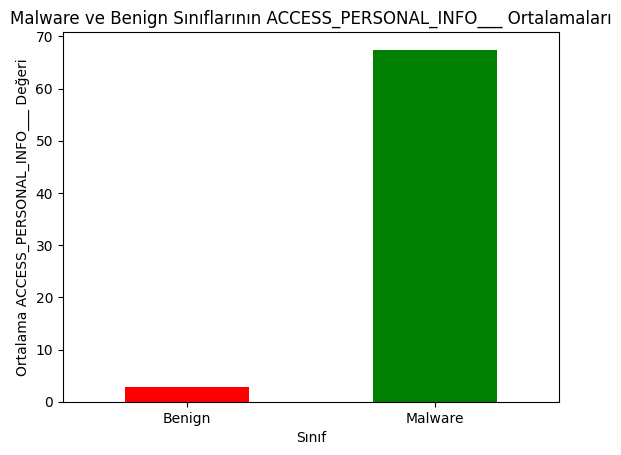

In [41]:
mean_access_info.plot(kind='bar', color=['red', 'green'])
plt.title('Malware ve Benign Sınıflarının ACCESS_PERSONAL_INFO___ Ortalamaları')
plt.ylabel('Ortalama ACCESS_PERSONAL_INFO___ Değeri')
plt.xlabel('Sınıf')
plt.xticks(rotation=0)
plt.show()

## 3. Veri Önişleme ve Feature Selection

In [42]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [43]:
num_features_to_select = 240
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_feature_indices = selector.get_support(indices=True)

X_train = X_train.iloc[:, selected_feature_indices]
X_test = X_test.iloc[:, selected_feature_indices]
X_train.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py:189: UserWarning: Features [157 169 171 191 275 315 320 352 436 456] are constant.
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,ACCESS_PERSONAL_INFO___,CREATE_FOLDER_____,CREATE_PROCESS`_____,CREATE_THREAD_____,DEVICE_ACCESS_____,EXECUTE_____,FS_ACCESS____,FS_ACCESS()____,FS_ACCESS(CREATE)____,FS_ACCESS(CREATE__APPEND)__,...,toggleSoftInput,ugetrlimit,uname,unlink,unregisterContentObserver,utimes,vfork,windowGainedFocus,write,writev
6227,3549,2,0,10,2,0,16,0,2,0,...,0,0,1,0,0,0,0,5,475,45
3009,1,0,0,8,2,0,4,0,1,0,...,0,0,1,0,0,0,0,0,28,5
994,1,0,0,18,2,0,16,0,1,0,...,1,0,1,0,0,0,0,3,204,14
2778,12,3,1,14,26,1,26,1,3,0,...,0,1,1,1,0,0,0,0,955,33
8345,0,0,0,8,37,0,45,0,5,0,...,0,0,1,2,0,0,0,0,95,4


In [44]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Feature Importance

0.005 eşik değeri üzerinde kalan özellik sayısı: 74


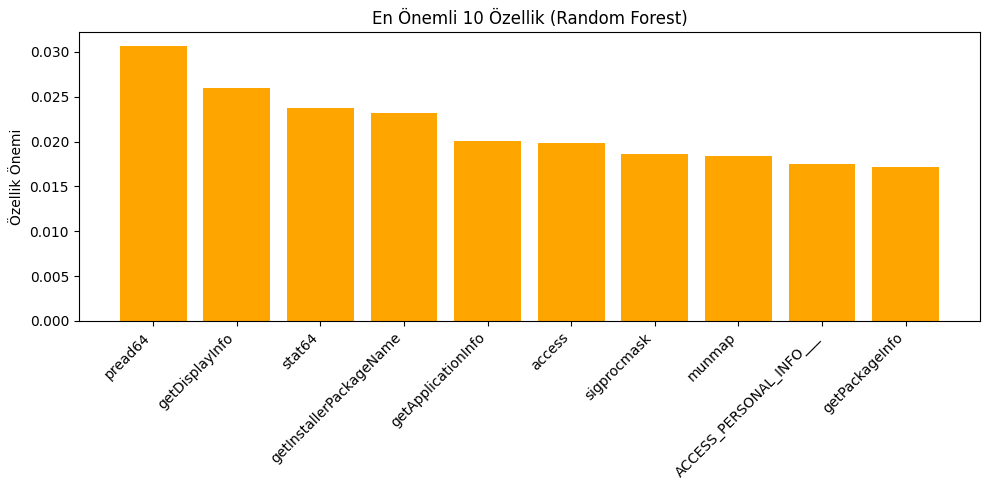

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

threshold = 0.005
important_indices = np.where(importances > threshold)[0]
important_importances = importances[important_indices]

selected_feature_names = X.columns[selected_feature_indices]
important_feature_names = selected_feature_names[important_indices]

sorted_indices = np.argsort(important_importances)[::-1]
sorted_feature_names = important_feature_names[sorted_indices]
sorted_importances = important_importances[sorted_indices]

top_n = 10
top_features = sorted_feature_names[:top_n]
top_importances = sorted_importances[:top_n]

print(f"0.005 eşik değeri üzerinde kalan özellik sayısı: {len(sorted_feature_names)}")

plt.figure(figsize=(10, 5))
plt.bar(range(top_n), top_importances, color='orange')
plt.xticks(ticks=range(top_n), labels=top_features, rotation=45, ha='right')
plt.ylabel('Özellik Önemi')
plt.title('En Önemli 10 Özellik (Random Forest)')
plt.tight_layout()
plt.show()

In [46]:
X_train_selected = X_train[:, important_indices]
X_test_selected = X_test[:, important_indices]

## 5. Binary Classification


Decision Tree
Accuracy: 0.9642
Weighted F1 Score: 0.9644


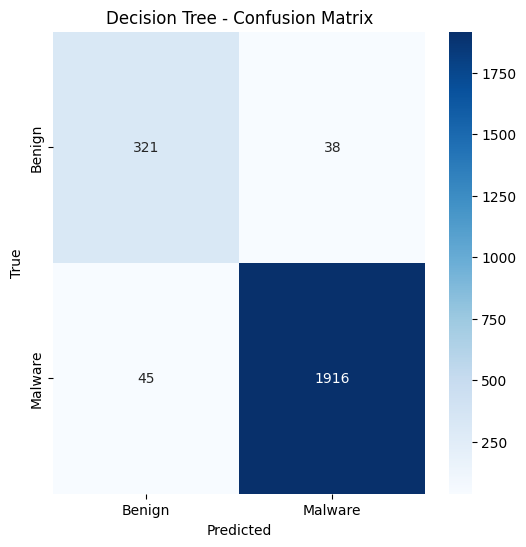


Random Forest
Accuracy: 0.9780
Weighted F1 Score: 0.9777


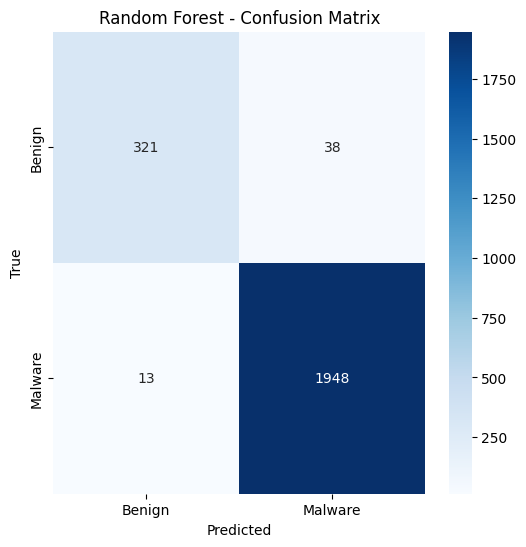


SVM
Accuracy: 0.9435
Weighted F1 Score: 0.9405


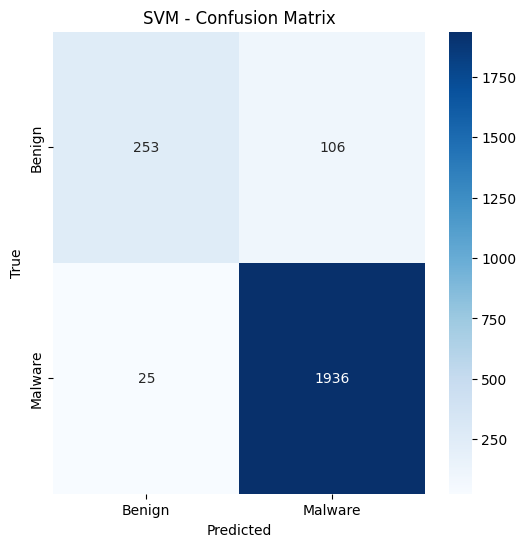

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [18:19:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
Accuracy: 0.9841
Weighted F1 Score: 0.9839


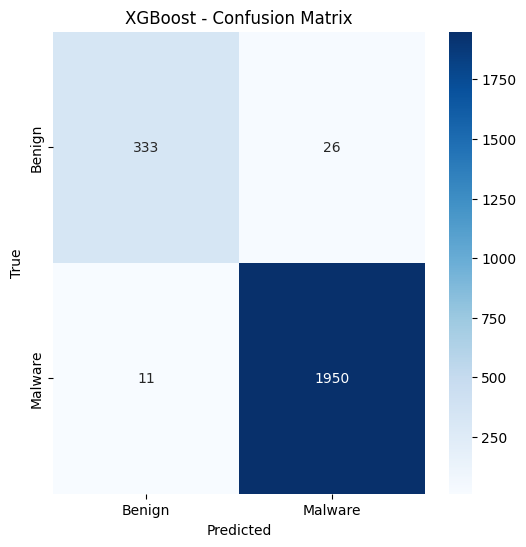

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Number of positive: 7842, number of negative: 1436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12510
[LightGBM] [Info] Number of data points in the train set: 9278, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.845225 -> initscore=1.697632
[LightGBM] [Info] Start training from score 1.697632

LightGBM
Accuracy: 0.9797
Weighted F1 Score: 0.9796


/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)


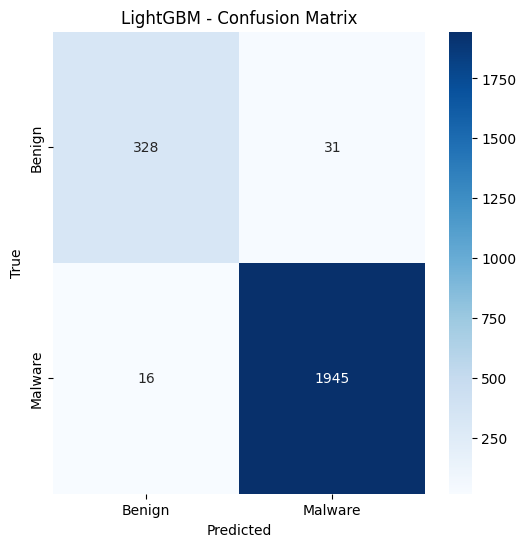

In [47]:
y_train_bin = y_train.apply(lambda x: 0 if x == 5 else 1)
y_test_bin = y_test.apply(lambda x: 0 if x == 5 else 1)

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_selected, y_train_bin)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred, average='weighted')

    cm = confusion_matrix(y_test_bin, y_pred)

    print(f"\n{name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## 6. XGBoost Binary Classification - Hiperparametre Optimizasyonu

Fitting 3 folds for each of 75 candidates, totalling 225 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [18:22:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


En iyi parametreler: {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100}
Optimized XGBoost Accuracy: 0.9828
Optimized XGBoost Weighted F1 Score: 0.9827


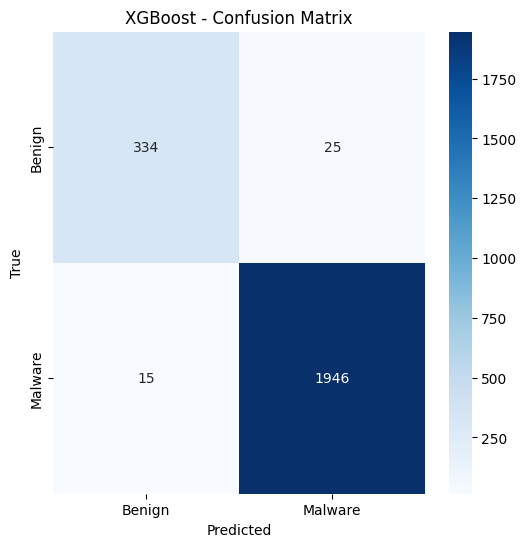

In [48]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train_selected, y_train_bin)

print("En iyi parametreler:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test_selected)

accuracy = accuracy_score(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred, average='weighted')

print(f"Optimized XGBoost Accuracy: {accuracy:.4f}")
print(f"Optimized XGBoost Weighted F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test_bin, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7. 5 Class Classification

In [49]:
class_names = [label_map[i] for i in sorted(label_map.keys())]
class_names

['Adware', 'Banking', 'SMS malware', 'Riskware', 'Benign']


Decision Tree
Accuracy: 0.9065
Weighted F1 Score: 0.9065


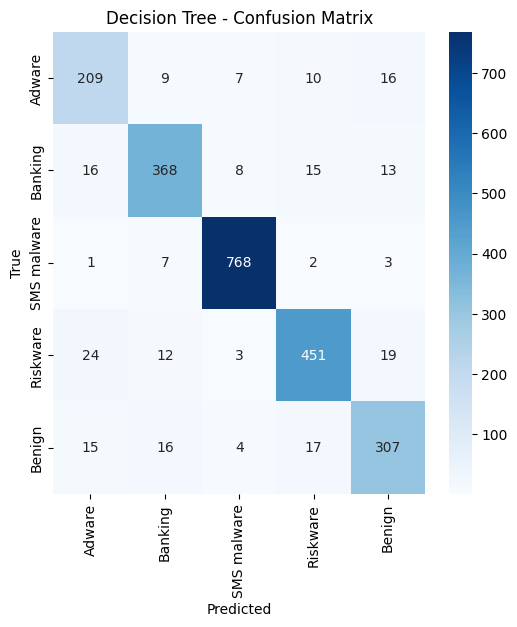


Random Forest
Accuracy: 0.9448
Weighted F1 Score: 0.9449


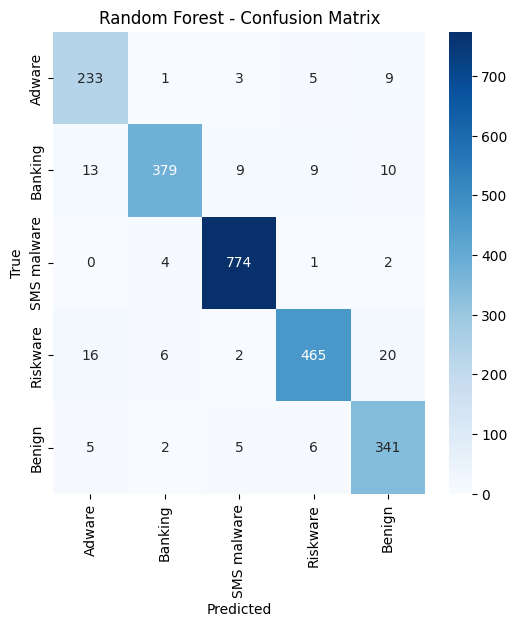


SVM
Accuracy: 0.7444
Weighted F1 Score: 0.7349


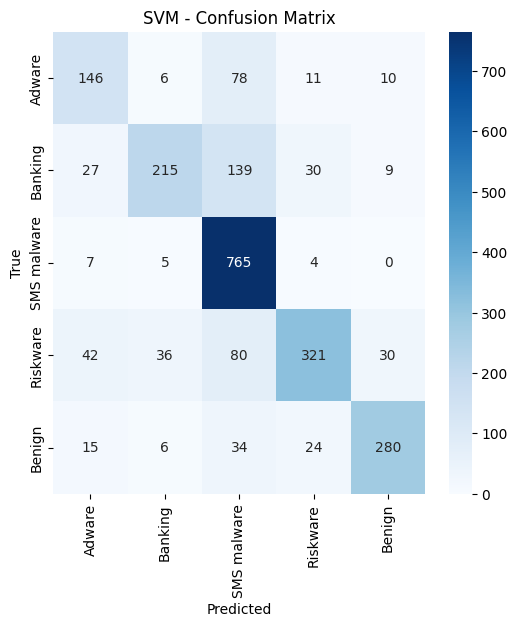

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:181: UserWarning: [18:23:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
Accuracy: 0.9500
Weighted F1 Score: 0.9499


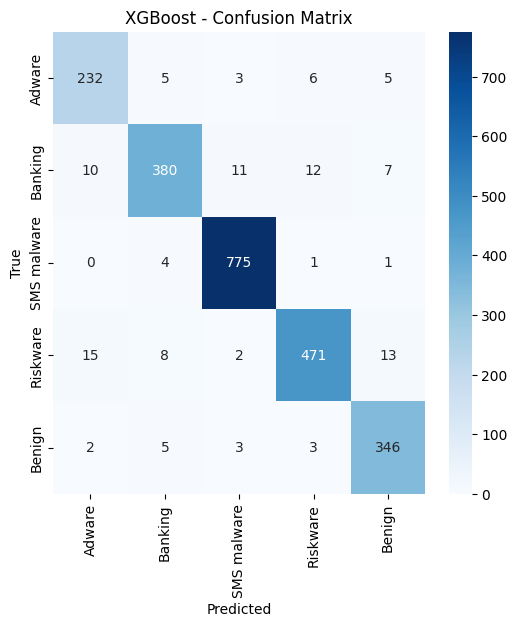

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:865: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  _X, _y = _LGBMCheckXY(X, y, accept_sparse=True, force_all_finite=False, ensure_min_samples=2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12510
[LightGBM] [Info] Number of data points in the train set: 9278, number of used features: 74
[LightGBM] [Info] Start training from score -2.225648
[LightGBM] [Info] Start training from score -1.708852
[LightGBM] [Info] Start training from score -1.088852
[LightGBM] [Info] Start training from score -1.516168
[LightGBM] [Info] Start training from score -1.865785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py:1007: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  X = _LGBMCheckArray(X, accept_sparse=True, force_all_finite=False)



LightGBM
Accuracy: 0.9496
Weighted F1 Score: 0.9495


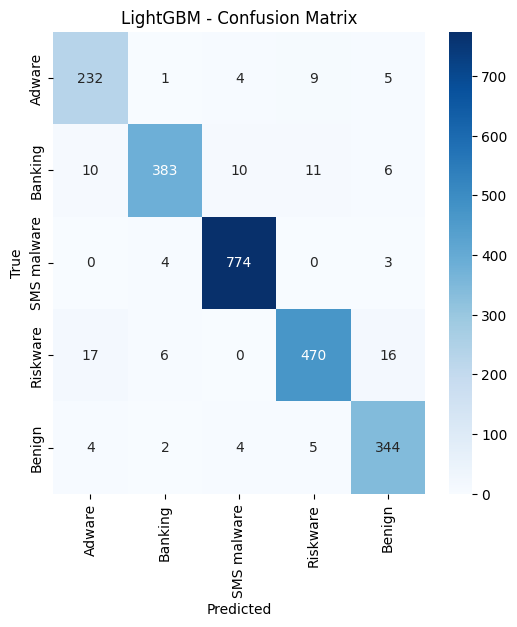

In [50]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, learning_rate=0.3, max_depth=15, n_estimators=100),
    'LightGBM': LGBMClassifier(random_state=42, learning_rate=0.3, max_depth=15, n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train_selected, y_train_adjusted)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test_adjusted, y_pred)
    f1 = f1_score(y_test_adjusted, y_pred, average='weighted')

    cm = confusion_matrix(y_test_adjusted, y_pred)

    print(f"\n{name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()